In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
df = pd.read_csv("housing.csv")

In [3]:
df = df.drop(columns = "ocean_proximity")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
missing_feat = df.isna().sum()[df.isna().sum()>0]

print(f"feature with missing values : {missing_feat.index[0]}\n no. of missing values : {missing_feat.iloc[0]}")

#missing_feat = [val for val in df_simp.columns if df_simp.isna().sum()[val] > 0]

feature with missing values : total_bedrooms
 no. of missing values : 207


As shown by the figure, the data does not have a long tail


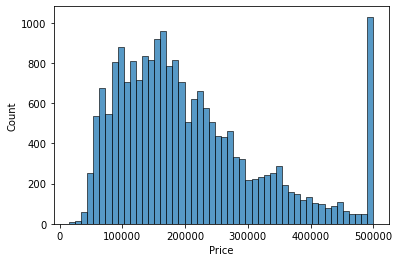

In [6]:
sns.histplot(df["median_house_value"], bins = 50);
plt.xlabel("Price");
print("As shown by the figure, the data does not have a long tail")

In [7]:
median_pop = df["population"].median()

print(f"The median for the feature 'population' is : {median_pop}")
#df_simp["population"].describe()["50%"]
#df_simp["population"].quantile(0.5)

The median for the feature 'population' is : 1166.0


In [8]:
n = df.shape[0]
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)
df = df.iloc[idx]
df.reset_index(drop = True, inplace = True)

In [11]:
n_train = int(n * 0.6)
n_val = int(n * 0.2)  
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train: n_train + n_val].reset_index(drop = True)
df_test = df.iloc[n_train + n_val :].reset_index(drop = True)

In [12]:
target = "median_house_value"
y_train, y_val, y_test = df_train[target], df_val[target], df_test[target]
X_train, X_val, X_test = df_train.drop(columns = target), df_val.drop(columns = target), df_test.drop(columns = target) 

In [13]:
y_train, y_val, y_test = y_train.apply(np.log1p), y_val.apply(np.log1p), y_test.apply(np.log1p)

In [14]:
#baseline 
y_train_mean = y_train.mean()
y_train_baseline = [y_train_mean] * len(y_train)
base_MSE_train = mean_squared_error(y_train, y_train_baseline)
base_MSE_train

0.32178002835041325

In [36]:
def linear_regression_fit(xi, yi):
    X_intercept = pd.DataFrame([1] * len(xi))
    X_new = pd.concat([X_intercept, xi], axis = 1) 
    w = np.dot(np.dot(np.linalg.inv(np.dot(X_new.T, X_new)), X_new.T), yi) 
    return w
def predict(xi, w):
    X_intercept = pd.DataFrame([1] * len(xi))
    X_new = pd.concat([X_intercept, xi], axis = 1) 
    y_pred = np.dot(X_new, w) 
    return y_pred

In [40]:
mean_miss = X_train["total_bedrooms"].mean()
median_miss = X_train["total_bedrooms"].median()
RMSE = []
pred = []
fill_options = [0, mean_miss, median_miss]
for val in fill_options:
    X_temp = X_train.copy()
    X_temp["total_bedrooms"].fillna(val, inplace = True)
    coef = linear_regression_fit(X_temp, y_train)
    y_pred = predict(X_val, coef)
    pred.append(y_pred)
    RMSE.append(round(np.sqrt(((y_pred - y_val)**2).mean()), 2))

In [87]:
print("RMSE scores for a linear regression model without regularization\n fill options being 0, mean and median : ")
RMSE

RMSE scores for a linear regression model without regularization
 fill options being 0, mean and median : 


[0.33, 0.33, 0.33]

In [42]:
y_pred

array([11.4640354 , 12.05943889, 12.65457022, ..., 11.68175656,
       12.17471961, 12.24031105])

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

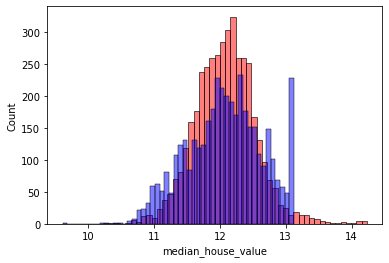

In [46]:
sns.histplot(y_pred, color = "red", alpha = 0.5, bins = 50)
sns.histplot(y_val, color = "blue", alpha = 0.5, bins = 50)

In [47]:
X_reg = X_train.copy()

In [48]:
X_reg["total_bedrooms"].fillna(0, inplace = True)

In [62]:
r = [0, 0.000001, 0.001, 0.01, 0.1, 1, 5, 10]
score = []
for val in r: 
    X_i = pd.DataFrame([1] * len(X_train))
    X_n = pd.concat([X_i, X_reg], axis = 1)
    XTX = np.dot(X_n.T, X_n)
    ld = val * np.eye(len(XTX))
    w_n = np.dot(np.dot(np.linalg.inv(XTX + ld), X_n.T), y_train)
    y_pred_n = predict(X_val, w_n)
    score.append(round(np.sqrt(((y_pred_n - y_val)**2).mean()), 2))

In [90]:
print(f"RMSE scores for a regularized linear regression model tuned with r = {r} respectively:")
score

RMSE scores for a regularized linear regression model tuned with r = [0, 1e-06, 0.001, 0.01, 0.1, 1, 5, 10] respectively:


[0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.34, 0.34, 0.36]

In [77]:
n = df.shape[0]
seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
metrics_score = []
for val in seed:
    np.random.seed(val)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df = df.iloc[idx]
    df.reset_index(drop = True, inplace = True)
    n_train = int(n * 0.6)
    n_val = int(n * 0.2)  
    df_train = df.iloc[:n_train]
    df_val = df.iloc[n_train: n_train + n_val].reset_index(drop = True)
    df_test = df.iloc[n_train + n_val :].reset_index(drop = True)
    target = "median_house_value"
    y_train, y_val, y_test = df_train[target], df_val[target], df_test[target]
    X_train, X_val, X_test = df_train.drop(columns = target), df_val.drop(columns = target), df_test.drop(columns = target) 
    y_train, y_val, y_test = y_train.apply(np.log1p), y_val.apply(np.log1p), y_test.apply(np.log1p)
    X_temp = X_train.copy()
    X_temp["total_bedrooms"].fillna(0, inplace = True)
    coef = linear_regression_fit(X_temp, y_train)
    y_pred = predict(X_val, coef)
    metrics_score.append(round(np.sqrt(((y_pred - y_val)**2).mean()), 2))

In [96]:
deviation = round(np.std(metrics_score), 3)
print(f"standard deviation of RMSE for a linear regression model without regularization for the following seeds {seed}:")
print(deviation)
print("Our model is stable")

standard deviation of RMSE for a linear regression model without regularization for the following seeds [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
0.005
Our model is stable


In [85]:
final_RMSE = 0
n = df.shape[0]
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)
df = df.iloc[idx]
df.reset_index(drop = True, inplace = True)
n_train = int(n * 0.6)
n_val = int(n * 0.2)  
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train: n_train + n_val].reset_index(drop = True)
df_test = df.iloc[n_train + n_val :].reset_index(drop = True)
target = "median_house_value"
y_train, y_val, y_test = df_train[target], df_val[target], df_test[target]
X_train, X_val, X_test = df_train.drop(columns = target), df_val.drop(columns = target), df_test.drop(columns = target) 
y_train, y_val, y_test = y_train.apply(np.log1p), y_val.apply(np.log1p), y_test.apply(np.log1p)
X_temp = X_train.copy()
X_full, y_full = pd.concat([X_temp, X_val], axis = 0, ignore_index = True), pd.concat([y_train, y_val], axis = 0, ignore_index = True)
X_full["total_bedrooms"].fillna(0, inplace = True)
X_i = pd.DataFrame([1] * len(X_full))
X_n = pd.concat([X_i, X_full], axis = 1)
XTX = np.dot(X_n.T, X_n)
ld = val * np.eye(len(XTX))
w_n = np.dot(np.dot(np.linalg.inv(XTX + ld), X_n.T), y_full)
y_pred_n = predict(X_test, w_n)
final_RMSE = round(np.sqrt(((y_pred_n - y_test)**2).mean()), 2)

In [98]:
print("RMSE on the test dataset for regularized linear regression model with seed being 9 and r = 0.001:")
final_RMSE

RMSE on the test dataset for regularized linear regression model with seed being 9 and r = 0.001:


0.35